In [2]:
##importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [34]:
##import the dataset
faces = pd.read_csv('../data/fer2013.csv')
faces.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [35]:
faces['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [36]:
#Somehow this version of data has more values in anger and neutral.
#We will only use happy, sad , calm and angry for generalizing the emotions.
# https://pandas.pydata.org/docs/getting_started/intro_tutorials/03_subset_data.html
#this is how you make subsets of data frame or filter them look uip documentations
faces = faces[faces['emotion'].isin([0,3,4,6])]

In [37]:
faces['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
0    4953
Name: count, dtype: int64

Initial Mapping
- 0: Angry
- 1: Digust
- 2: Fear
- 3: Happy
- 4: Sad
- 5: Surprise
- 6: Neutral 

Lets map such that:
- 0 : Anger
- 1 : Happy
- 2 : Sad
- 3 : Neutral

In [38]:
## !! MAKE SURE YOU DONT REPLACE TWICE !!
faces['emotion'].replace({3:1,4:2,6:3},inplace= True)
faces['emotion'].value_counts() 


emotion
1    8989
3    6198
2    6077
0    4953
Name: count, dtype: int64

Lets see how many of them are in training and testing

In [39]:
faces.groupby('Usage')['emotion'].value_counts()

Usage        emotion
PrivateTest  1           879
             3           626
             2           594
             0           491
PublicTest   1           895
             2           653
             3           607
             0           467
Training     1          7215
             3          4965
             2          4830
             0          3995
Name: count, dtype: int64

The classes are evenly distributed except the happy class in training

In [40]:
def get_pix(str_pix):
    img = np.array(str_pix.split(),dtype =float) 
    #this will give a list from the string for instance [233,181,135]. 
    #pixels.split gives a list and np.array converts the list to array
    # For the neural network, the neural networks wants an extra dimension for the color space like rgb or grayscale. Lets add that
    img = img.reshape(48,48,1) # reshape the 1d array to 2d array of dimensions 48x48x1
    return img.astype(np.uint8) #return tuple of img with required datatype and emotion label

In [41]:
faces['pixels'] = faces['pixels'].apply(lambda x: get_pix(x))

In [42]:
faces.head()

,emotion,pixels,Usage
0,0,"[[[70], [80], [82], [72], [58], [58], [60], [6...",Training
1,0,"[[[151], [150], [147], [155], [148], [133], [1...",Training
3,2,"[[[24], [32], [36], [30], [32], [23], [19], [2...",Training
4,3,"[[[4], [0], [0], [0], [0], [0], [0], [0], [0],...",Training
6,2,"[[[20], [17], [19], [21], [25], [38], [42], [4...",Training


In [43]:
faces['Usage'].value_counts()

Usage
Training       21005
PublicTest      2622
PrivateTest     2590
Name: count, dtype: int64

In [44]:
train_x = faces[faces['Usage'] == 'Training']['pixels']  #First subset the dataframe according to the value in Usage and then take the pixels as the independent variable for training
train_y = faces[faces['Usage'] == 'Training']['emotion']  #First subset the dataframe according to the value in usage and then take the emotion as the dependent variable for training
val_x = faces[faces['Usage'] == 'PrivateTest']['pixels']  #First subset the dataframe according to the value in Usage and then take the pixels as the independent variable for validation
val_y = faces[faces['Usage'] == 'PrivateTest']['emotion']  #First subset the dataframe according to the value in Usage and then take the emotion as the dependent variable for validation
test_x = faces[faces['Usage'] == 'PublicTest']['pixels']  #First subset the dataframe according to the value in Usage and then take the pixels as the independent variable for testing
test_y = faces[faces['Usage'] == 'PublicTest']['emotion']  #First subset the dataframe according to the value in Usage and then take the emotion as the dependent variable for testing


Why do we split into train test and validation?

- When building Neural Network, the model uses the training data to build the model and adjust the parameters such as weights.
- validation data is used to validate the model such as adjusting hyperparameters, avoid overfitting and for early stoping( look up in google ). 
- The testing data is used as completely new data to the model. It is essential as there will be data leaks with validation data and if that is used as testing the model will be biased since it has already seen that data.

In [33]:
train_x.shape

(21005,)

In [45]:
num_classes = 4
width, height = 48, 48
num_epochs = 50
batch_size = 64
num_features = 64

# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert uint8 to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

from keras.utils import to_categorical
def CRNO(X,y, dataName):
    data_X = np.array(X.tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(y, num_classes)  
    print(dataName, f"_X shape: {data_X.shape}, ", dataName, f"_Y shape: {data_Y.shape}")
    return data_X, data_Y

    
train_X, train_Y = CRNO(train_x,train_y,"train") #training data
val_X, val_Y     = CRNO(val_x,val_y, "val") #validation data
test_X, test_Y   = CRNO(test_x,test_y, "test") #test data

train _X shape: {},  train _Y shape: (21005, 48, 48, 1)
val _X shape: {},  val _Y shape: (2590, 48, 48, 1)
test _X shape: {},  test _Y shape: (2622, 48, 48, 1)


In [46]:

model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

c:\Users\bimal\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 256)    │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 46, 46, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 46, 46, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 46, 46, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 23, 23, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 23, 23, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             

 Total params: 2,137,604 (8.15 MB)

 Trainable params: 2,134,020 (8.14 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [50]:
from sklearn.utils.class_weight import compute_class_weight

# Add Early Stopping Callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # You can monitor 'val_accuracy' as well
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model with the best weights
)

class_weights = compute_class_weight('balanced', classes=np.unique(train_Y), y=train_Y)
class_weights_dict = dict(enumerate(class_weights))
history = model.fit(train_X, train_Y,
                    epochs=num_epochs,
                    batch_size=batch_size,
                    validation_data=(val_X, val_Y),
                    class_weight = class_weights_dict, #for class imbalance 
                    callbacks = [early_stopping]) 

Epoch 1/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 861s 3s/step - accuracy: 0.3821 - loss: 1.3742 - val_accuracy: 0.3892 - val_loss: 1.3008
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 849s 3s/step - accuracy: 0.5882 - loss: 1.0070 - val_accuracy: 0.6042 - val_loss: 0.9681
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 798s 2s/step - accuracy: 0.6581 - loss: 0.8589 - val_accuracy: 0.6093 - val_loss: 0.9100
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 797s 2s/step - accuracy: 0.7144 - loss: 0.7372 - val_accuracy: 0.6351 - val_loss: 0.8834
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 799s 2s/step - accuracy: 0.7565 - loss: 0.6502 - val_accuracy: 0.6220 - val_loss: 0.9351
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 795s 2s/step - accuracy: 0.7959 - loss: 0.5453 - val_accuracy: 0.6355 - val_loss: 0.9570
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 794s 2s/step - accuracy: 0.8476 - loss: 0.4295 - val_accuracy: 0.6301 - val_loss: 1.1435
Epoch 8/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 794s 2s/step - accuracy: 0.8805 - loss: 0.3387 - val_accu

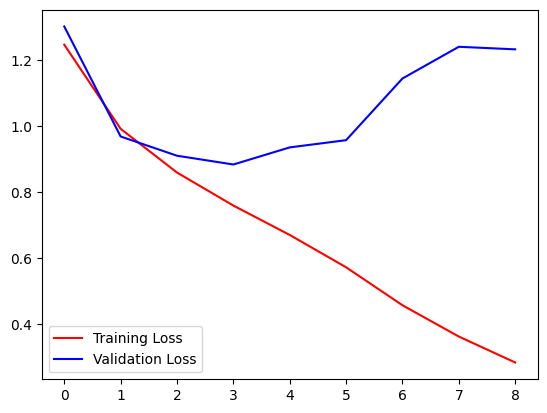

In [51]:
def loss_plot(history):
  plt.plot(history.history["loss"],'r', label="Training Loss")
  plt.plot(history.history["val_loss"],'b', label="Validation Loss")
  plt.legend()

loss_plot(history)

In [52]:
# Model Inference
preds = model.predict(test_X)
y_pred = np.argmax(preds , axis = 1 )

82/82 ━━━━━━━━━━━━━━━━━━━━ 23s 276ms/step


In [54]:
print(classification_report(np.argmax(test_Y, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.505     0.597     0.548       467
           1      0.876     0.726     0.794       895
           2      0.531     0.591     0.559       653
           3      0.544     0.539     0.541       607

    accuracy                          0.626      2622
   macro avg      0.614     0.613     0.611      2622
weighted avg      0.647     0.626     0.633      2622



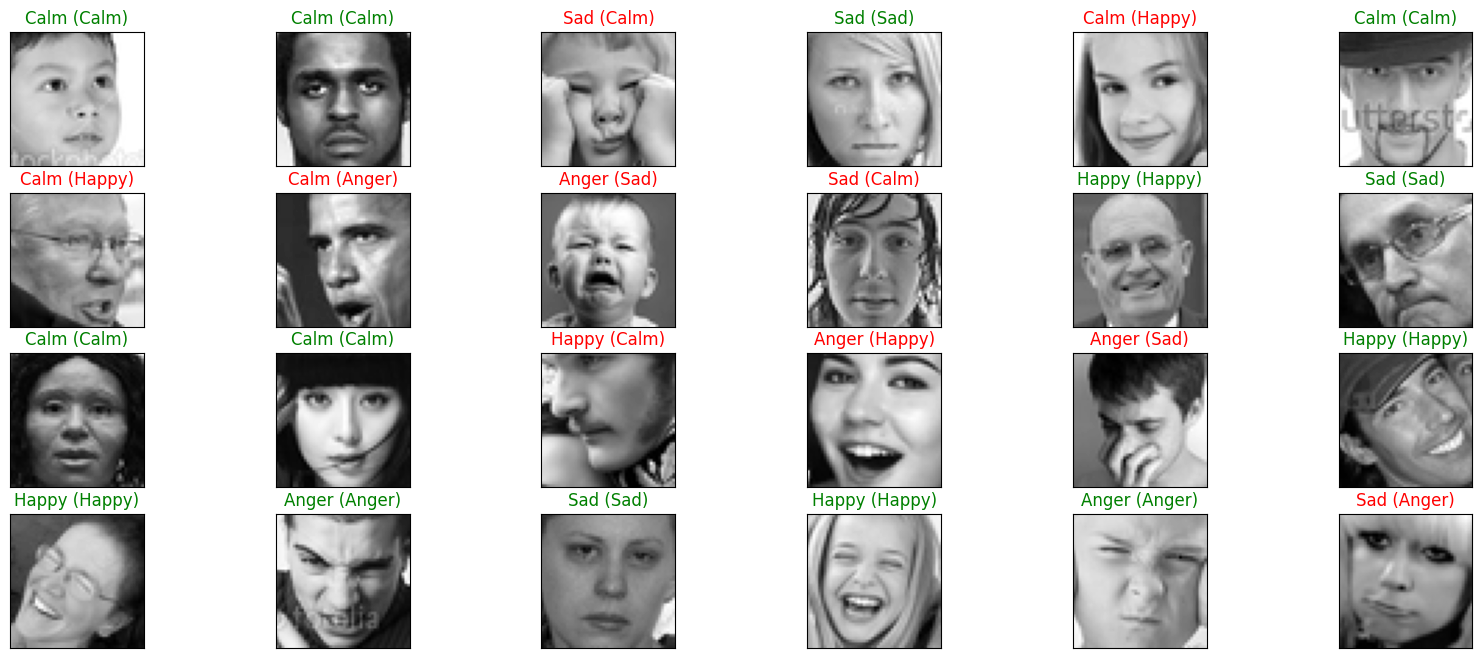

In [56]:
emotion_map = {0 : 'Anger',1 : 'Happy', 2 : 'Sad',3 : 'Calm'}
#function to plot images with their lables(actual vs predicted)
def check_images(X_test,y_pred,label_dict):

  figure = plt.figure(figsize=(20, 8))
  for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
      ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
      ax.imshow(np.squeeze(X_test[index]),cmap="gray")
      predict_index = label_dict[(y_pred[index])]
      true_index = label_dict[np.argmax(test_Y,axis=1)[index]]
      
      ax.set_title("{} ({})".format((predict_index), 
                                    (true_index)),
                                    color=("green" if predict_index == true_index else "red"))
check_images(test_X,y_pred,emotion_map)

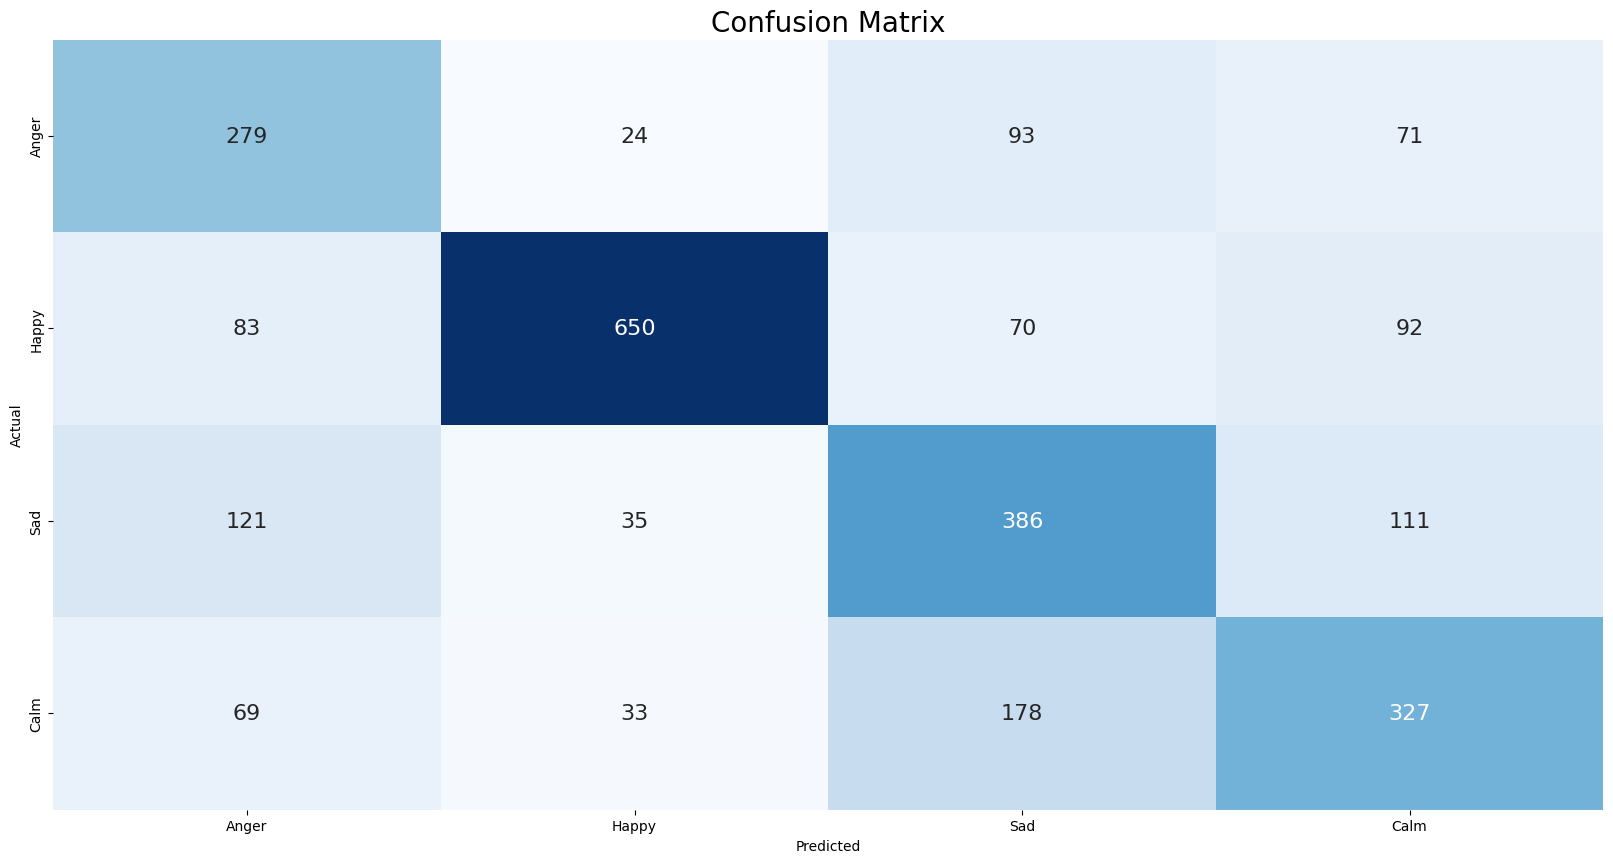

In [60]:
import seaborn as sns
# function to plot confusion matrix
def conf_mat(y_test,y_pred,labels):
  CLASS_LABELS  = list(labels.values())
  cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
  cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
  cm.index.name = 'Actual'
  cm.columns.name = 'Predicted'
  plt.figure(figsize = (20,10))
  plt.title('Confusion Matrix', fontsize = 20)
  sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')
conf_mat(test_Y,y_pred,emotion_map)

In [62]:
# loss and accuracy
met_train = model.evaluate(train_X,train_Y)
print("On Training Data",met_train)

met_val = model.evaluate(val_X,val_Y)
print("On Validation Data",met_val)

met_test = model.evaluate(test_X,test_Y)
print("On Test Data",met_test)

657/657 ━━━━━━━━━━━━━━━━━━━━ 178s 272ms/step - accuracy: 0.7130 - loss: 0.7169
On Training Data [0.7090165615081787, 0.718686044216156]
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.6252 - loss: 0.8997
On Validation Data [0.8834110498428345, 0.6351351141929626]
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - accuracy: 0.6299 - loss: 0.9058
On Test Data [0.9266316294670105, 0.626239538192749]


In [64]:
import pickle
with open('../model/model_v3.pkl', 'wb') as file:
    pickle.dump(model, file)